# Guitar tuner

Diego Torres
Philippe Massouf

In [27]:
#imports
import numpy as np
import scipy as sp  
from scipy.io.wavfile import read
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt
import plotly.express as px

# Plotting the signal

In [28]:
sr, signal = read('string_2.wav')

In [29]:
yf = fft(signal)

In [30]:
xf = fftfreq(len(signal), 1 / sr)

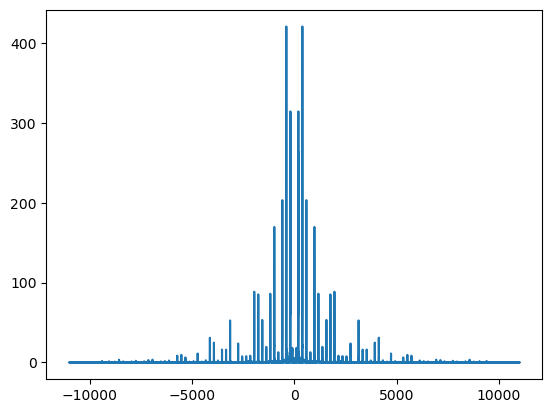

In [31]:
plt.plot(xf, 2.0/len(signal) * np.abs(yf))

In [32]:
fig = px.line(x=xf[:len(signal)//2], y=2.0/len(signal) * np.abs(yf[:len(signal)//2]), labels={'x':'x-axis', 'y':'y-axis'}, title='Simple Line Plot')
fig.show()

# Peak detection algorithm

In [33]:
def get_freq(sr, signal):
    yf = fft(signal)
    xf = fftfreq(len(signal), 1 / sr)
    pos_x = xf[:len(signal)//2]
    pos_y = np.abs(yf[:len(signal)//2])
    argsort = pos_y.argsort()
    first_peak = pos_x[argsort[-1]]
    i = 1
    second_peak = pos_x[argsort[-(1+i)]]
    while diff := first_peak - second_peak < 20:
        i += 1
        second_peak = pos_x[argsort[-(1+i)]]

    first_peak_ix = argsort[-1]
    second_peak_ix = argsort[-(1+i)]

    if first_peak_ix < second_peak_ix:
        return first_peak
    
    first_peak_integral = pos_y[first_peak_ix-10:first_peak_ix+10].sum()
    second_peak_integral = pos_y[second_peak_ix-10:second_peak_ix+10].sum()

    if first_peak_integral > second_peak_integral:
        return first_peak
    
    return second_peak

In [34]:
notes = {
    "E1": 329.63,
    "B2": 246.94,
    "G3": 196.00,
    "D4": 146.83,
    "A5": 110.00,
    "E6": 82.41
}
cents = {
    "E1": 0.15,
    "B2": 0.15,
    "G3": 0.15,
    "D4": 0.08,
    "A5": 0.08,
    "E6": 0.04
}

# Finding the fundamental frequency and the note

In [35]:
def solve_exercise(file_name):
    freq = get_freq(*read(file_name))
    note = min(notes, key=lambda x: abs(notes[x] - freq))
    accuracy = abs(notes[note] - freq)/cents[note]

    print(f"Frequency: {freq:.3f}, Note: {note}, Accuracy: {accuracy:.2f} cents")

In [36]:
solve_exercise("string_1.wav")

Frequency: 329.681, Note: E1, Accuracy: 0.34 cents


In [37]:
solve_exercise("string_2.wav")

Frequency: 196.541, Note: G3, Accuracy: 3.61 cents


In [38]:
solve_exercise("string_3.wav")

Frequency: 110.122, Note: A5, Accuracy: 1.53 cents


# Harmonic Product Spectrum method
http://musicweb.ucsd.edu/~trsmyth/analysis/Harmonic_Product_Spectrum.html

In [39]:
def get_freq_hps(sr, signal, partials=5):
    spectrum = np.abs(fft(signal))
    spectra = [spectrum]

    # Downsampling the spectrum for the given number of partials
    for n in range(2, partials + 1):
        downsampled = sp.signal.resample(spectrum, len(spectrum) // n)
        spectra.append(downsampled)

    # Truncating spectra to the length of the most downsampled spectrum
    min_length = min([len(s) for s in spectra])
    spectra = [s[:min_length] for s in spectra]

    # Multiplying the spectra together to get the product spectrum
    hps = np.prod(np.array(spectra), axis=0)
    
    # Extracting frequencies corresponding to the spectrum
    frequencies = fftfreq(len(signal), 1 / sr)
    positive_frequencies = frequencies[:min_length]

    # Finding the frequency corresponding to the highest peak in the HPS
    fundamental_frequency = positive_frequencies[np.argmax(hps)]

    return fundamental_frequency


In [40]:
def solve_exercise(file_name):
    freq = get_freq_hps(*read(file_name))
    note = min(notes, key=lambda x: abs(notes[x] - freq))
    accuracy = abs(notes[note] - freq)/cents[note]

    print(f"Frequency: {freq:.3f}, Note: {note}, Accuracy: {accuracy:.2f} cents")

In [41]:
solve_exercise("string_1.wav")

Frequency: 329.681, Note: E1, Accuracy: 0.34 cents


In [42]:
solve_exercise("string_2.wav")

Frequency: 195.980, Note: G3, Accuracy: 0.13 cents


In [43]:
solve_exercise("string_3.wav")

Frequency: 110.122, Note: A5, Accuracy: 1.53 cents
